# Evaluate likelihood ratio

In [29]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from scipy.stats import norm
from sklearn.metrics import roc_curve

from simulation.population_sim import SubhaloSimulator
from inference.estimator import ParameterizedRatioEstimator
from inference.utils import s_from_r, shuffle

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Data

In [30]:
np.load("../data/samples/theta_test.npy")

array([[10. , -1.9],
       [10. , -1.9],
       [10. , -1.9],
       ...,
       [10. , -1.9],
       [10. , -1.9],
       [10. , -1.9]])

In [31]:
xs = np.load("../data/samples/x_test.npy")

In [32]:
np.max(xs[0])

12717

In [34]:
idx = list(range(5))
nrows = len(idx)

In [54]:
filenames = ["carl", "alices_deep"]
labels = ["CARL (18)", "ALICES (50)"]
colors = ["blue", "yellow", "red"]
ncols = 1 + len(filenames)

In [55]:
llrs = [np.load("../data/results/llr_{}_grid.npy".format(filename)) for filename in filenames]
grads = [np.load("../data/results/grad_x_{}_grid.npy".format(filename)) for filename in filenames]

In [56]:
grid_res = 25

alpha_test = np.linspace(1., 19., grid_res)
beta_test = np.linspace(-1., -2.8, grid_res)

theta0, theta1 = np.meshgrid(alpha_test, beta_test)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = alpha_test[1] - alpha_test[0]
alpha_edges = np.linspace(alpha_test[0] - bin_size/2, alpha_test[-1] + bin_size/2, grid_res + 1)
bin_size = beta_test[1] - beta_test[0]
beta_edges = np.linspace(beta_test[0] - bin_size/2, beta_test[-1] + bin_size/2, grid_res + 1)

## Plotting options

In [66]:
llrmin, llrmax = -10., 10.
gradmin, gradmax = 0., 0.001
xmin, xmax = 2., 3.5

alphas = 0.4

In [67]:
overlay_cmaps = []
for i, color in enumerate(colors):
    rgba = colorConverter.to_rgba(color)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('overlay_cmap_{}'.format(i),[rgba,rgba],256)
    cmap._init()
    alphas = np.linspace(0, alpha_grad, cmap.N+3)
    cmap._lut[:,-1] = alphas
    overlay_cmaps.append(cmap)

## Plot

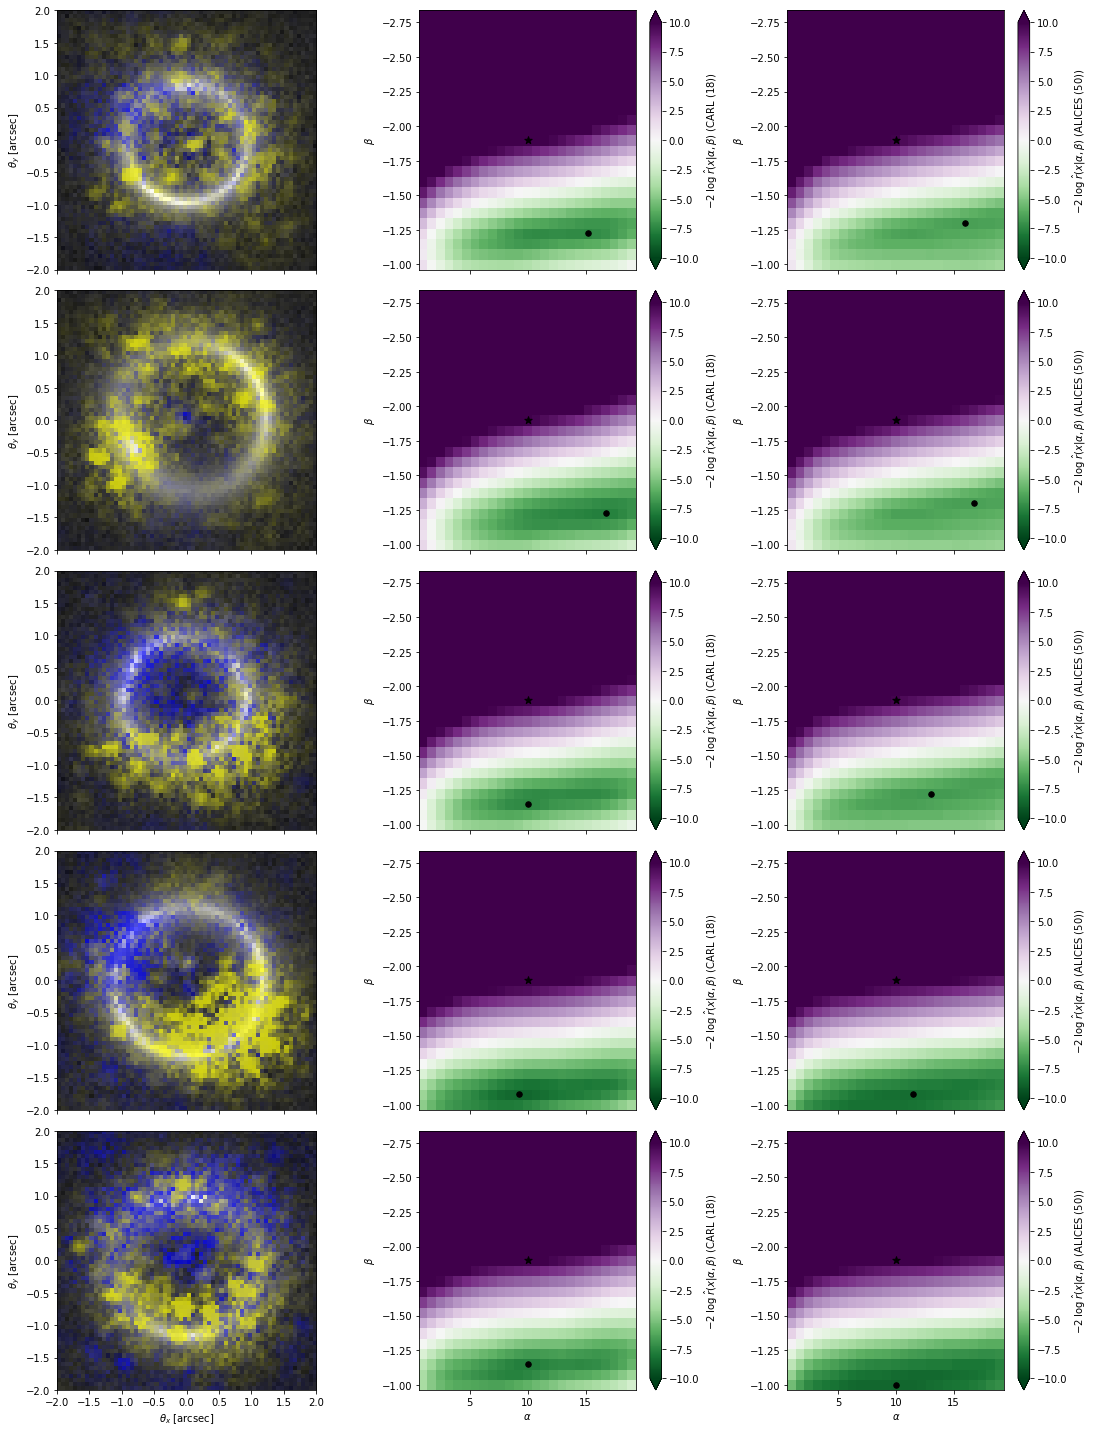

In [68]:
fig = plt.figure(figsize=(5*ncols, 4*nrows))
ax_rs = []

for i in [nrows - 1] + list(range(nrows - 1)):
    # Plot image
    if i == nrows - 1:
        ax_img = plt.subplot(nrows, ncols, i*ncols+1)
        ax = ax_img
    else:
        ax = plt.subplot(nrows, ncols, i*ncols+1, sharex=ax_img)
    
    plt.imshow(
        np.log10(xs[i]),
        vmin=xmin,
        vmax=xmax,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    
    if True:
        for k in range(ncols - 1):
            plt.imshow(
                np.abs(grads[k][i]),
                vmin=gradmin,
                vmax=gradmax,
                cmap=overlay_cmaps[k],
                extent=(-2.,2.,-2.,2.),
                origin="lower"
            )

    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    if i == nrows - 1:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r"$\theta_y$ [arcsec]")
    
    
    
    # Plot estimated likelihood ratios
    for k in range(ncols - 1):
        if i == nrows - 1:
            ax_rs.append(plt.subplot(nrows, ncols, i*ncols + k + 2))
            ax = ax_rs[k]
        else:
            ax = plt.subplot(nrows, ncols, i*ncols + k + 2, sharex=ax_rs[k])
        
        i_mle = np.argmax(llrs[k][:, i])
        theta_mle = theta_grid[i_mle]
        z = np.clip(-2. * llrs[k][:, i], llrmin, llrmax)
    
        pcm = ax.pcolormesh(
            alpha_edges,
            beta_edges,
            z.reshape((grid_res, grid_res)),
            norm=matplotlib.colors.Normalize(vmin=llrmin, vmax=llrmax),
            cmap='PRGn_r'
        )
        cbar = fig.colorbar(pcm, ax=ax, extend='both')
        plt.scatter(10., -1.9, s=60., color='black', marker='*')
        plt.scatter(theta_mle[0], theta_mle[1], s=30., color='black', marker='o')

        if i == nrows - 1:
            plt.xlabel(r'$\alpha$')
        else:
            plt.setp(plt.gca().get_xticklabels(), visible=False)
        plt.ylabel(r'$\beta$')
        cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ ' + '({})'.format(labels[k]))
        plt.xlim(alpha_edges[0], alpha_edges[-1])
        plt.ylim(beta_edges[0], beta_edges[-1])
    
                         
    
plt.tight_layout()
plt.savefig("../figures/predictions.pdf")

## Expected LLR

In [ ]:
fig = plt.figure(figsize=(5*ncols, 4*nrows))
ax_rs = []

# Plot image
ax = plt.subplot(1, ncols, i*ncols+1)

plt.imshow(
    np.log10(x_train[i]),
    vmin=xmin,
    vmax=xmax,
    cmap='gist_gray',
    extent=(-2.,2.,-2.,2.),
    origin="lower"
)

for k in range(ncols - 1):
    plt.imshow(
        np.abs(grads[k][i_mles[k],i]),
        vmin=gradmin,
        vmax=gradmax,
        cmap=overlay_cmaps[k],
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )

plt.xlim(-2.,2.)
plt.ylim(-2.,2.)
if i == nrows - 1:
    plt.xlabel(r"$\theta_x$ [arcsec]")
else:
    plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.ylabel(r"$\theta_y$ [arcsec]")
    
    
    
# Plot estimated likelihood ratios
for k in range(ncols - 1):
    ax = plt.subplot(nrows, ncols, i*ncols + k + 2)

    i_mle = np.argmax(llrs[k][:, i])
    theta_mle = theta_grid[i_mle]
    z = np.clip(-2. * llrs[k][:, i], llrmin, llrmax)

    pcm = ax.pcolormesh(
        alpha_edges,
        beta_edges,
        z.reshape((grid_res, grid_res)),
        norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
        cmap='PRGn_r'
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    plt.scatter(10., -1.9, s=60., color='black', marker='*')
    plt.scatter(theta_mle[0], theta_mle[1], s=30., color='black', marker='o')

    if i == nrows - 1:
        plt.xlabel(r'$\alpha$')
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    plt.ylabel(r'$\beta$')
    cbar.set_label(r'$-2\; \log \;\hat{r}(x | \alpha, \beta)$ ' + '({})'.format(labels[k]))
    plt.xlim(alpha_edges[0], alpha_edges[-1])
    plt.ylim(beta_edges[0], beta_edges[-1])
    
                         
    
plt.tight_layout()
plt.savefig("../figures/expected_llr.pdf")